In [1]:
import numpy as np
import torch as t
import matplotlib.pyplot as plt
import tqdm as tq
from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.animation as animation
import winsound
Freq = 1500 # Set Frequency To 2500 Hertz
Dur = 1000 # Set Duration To 1000 ms == 1 second

In [6]:
eta=1
b=1
R=t.pi
weight=1

ReLu=t.nn.ReLU()

def act(x):
    return t.sin(x)
#t.log(1+t.exp(x))

def dact(x):
    return t.cos(x)
#t.exp(x)/(1+t.exp(x))

def ddact(x):
    return -t.sin(x)
#t.exp(x)/((1+t.exp(x))**2)

def dddact(x):
    return -t.cos(x)
#(t.exp(x)*(1-t.exp(x)))/(1+t.exp(x))**4

def net(c,w,x):
    return t.matmul(c,act(w*x))

def dnet(c,w,x):
    return t.matmul(c*w,dact(w*x))

def ddnet(c,w,x):
    return t.matmul(c*w*w,ddact(w*x))

def PINN_Error(c,w,x):
    a=0
    N=x.size(0)
    e_val=eigenvalue(c,w,x)
    for i in range(N):
        s=-ddnet(c,w,x[i])+b*net(c,w,x[i])+eta*(net(c,w,x[i])**3)-e_val*net(c,w,x[i])
        a=a+(s)**2
    return (R/N)*a

        
def energy(c,w,x):
    e=0
    N=x.size(0)
    for i in range(N):
        e=e+(dnet(c,w,x[i])**2)+b*(net(c,w,x[i])**2)+(eta/2)*(net(c,w,x[i])**4)
    e=(R/N)*e
    return e


def eigenvalue(c,w,x):
    e=0
    N=x.size(0)
    for i in range(N):
        e=e+(dnet(c,w,x[i])**2)+b*(net(c,w,x[i])**2)+eta*(net(c,w,x[i])**4)
    e=(R/N)*e
    return e

def L2(c,w,x):
    a=0
    n=x.size(0)
    for i in range(n):
        a=a+net(c,w,x[i])**2
    return (R/n)*a
    
def Lag(c,w,x,L):
    return energy(c,w,x)+L*(L2(c,w,x)-1)
    
    
def Error_T(c,w,x):
    return energy(c,w,x)+(L2(c,w,x)-1)**2+net(c,w,t.zeros(1))**2+net(c,w,R)**2
    
    
def grad(c,w,x):
    m=c.size(0)
    N=x.size(0)
    grad_c=t.zeros(m)
    grad_w=t.zeros(m)
    for i in range(N):
        c_1=2*dnet(c,w,x[i])*(w*dact(w*x[i]))
        c_2=2*b*net(c,w,x[i])*act(w*x[i])
        c_3=4*(eta/2)*(net(c,w,x[i])**3)*act(w*x[i])
        c_b=2*net(c,w,R)*act(w*R)
        c_o=2*net(c,w,t.zeros(1))*act(w*t.zeros(1))
        c_n=4*(L2(c,w,x)-1)*net(c,w,x[i])*act(w*x[i])
        w_1=2*dnet(c,w,x[i])*c*(dact(w*x[i])+w*ddact(w*x[i])*x[i])
        w_2=2*b*net(c,w,x[i])*c*dact(w*x[i])*x[i]
        w_3=4*(eta/2)*(net(c,w,x[i])**3)*c*dact(w*x[i])*x[i]
        w_b=2*net(c,w,R)*c*dact(w*R)*R
        w_o=2*net(c,w,t.zeros(1))*c*dact(w*t.zeros(1))*t.zeros(1)
        w_n=4*(L2(c,w,x)-1)*net(c,w,x[i])*c*dact(w*x[i])*x[i]
        grad_c=grad_c+c_1+c_2+c_3+c_b+c_o+weight*c_n
        grad_w=grad_w+w_1+w_2+w_3+w_b+w_o+weight*w_n
    grad_c=(R/N)*grad_c
    grad_w=(R/N)*grad_w
    return grad_c, grad_w
    
    
def optimization(N,m,T,r):
    c=t.zeros(m)
    w=t.zeros(m)
    c[0]=1
    w[0]=1
    x=t.tensor([R*(i/N)  for i in range(N)])
    Error=t.zeros(T)
    Error_1=t.zeros(T)
    Error_2=t.zeros(T)
    Error_3=t.zeros(T)
    plots=[]
    for k in tq.tqdm(range(T)):
        G=grad(c,w,x)
        c=c-r*G[0]
        w=w-r*G[1]
        rc_L2=L2(c,w,x)
        a=t.tensor([net(c,w,x[i]) for i in range(N)])
        Sa=t.sign(a)*t.sign(a)
        G=0
        for i in range(N):
            G=G+(Sa[i]-1)
        if G==0:
            c=c/rc_L2
        Error[k]=energy(c,w,x)
        Error_1[k]=PINN_Error(c,w,x)
        Error_2[k]=rc_L2
        Error_3[k]=Error_T(c,w,x)
        if np.isnan(Error[k])==True:
            break
        #s=t.tensor([t.sign(net(c,w,x[i])) for i in range(N)])
        plt.plot(x,a)
        plt.xlabel(k/T)
        plt.ylabel("N="+str(N)+"..."+"m="+str(m)+"..."+"r="+str(r))
        if k==0:
            fig, ax = plt.figure(), plt.axes(xlim=(0, R), ylim=(-0.5, 1.5))
        else:
            dummy_fig, ax = plt.figure(), plt.axes(xlim=(0, R), ylim=(-0.5, 1.5))
            ax.set(animated=True)
            ax.remove()
            ax.figure = fig
            fig.add_axes(ax)
            plt.close(dummy_fig)
        
        plots.append([ax])

    ani = animation.ArtistAnimation(fig, plots, interval=50, repeat_delay=20000)
    ani.save("GPE_1copy.gif")
    winsound.Beep(Freq,Dur)
    winsound.Beep(Freq,Dur)
    return c,w,Error,Error_1,Error_2, Error_3

In [7]:
n=10
m=10
T=200
r=0.0001

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:18<00:00, 11.00it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


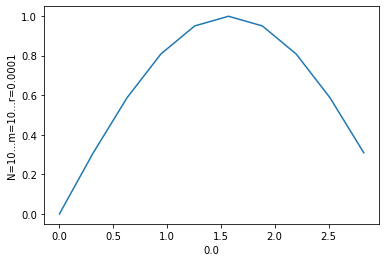

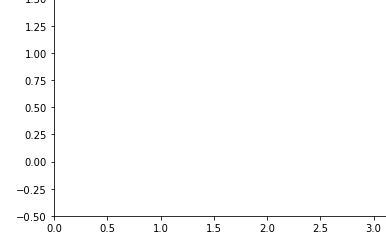

In [8]:
A=optimization(n,m,T,r)

In [ ]:
plt.plot(A[2]), A[2][-1]  #Energy

In [ ]:
plt.plot(A[3][2500:]), A[3][-1]  #PINN

In [ ]:
plt.plot(A[4][150:]), A[4][-1] #L2

In [ ]:
plt.plot(A[5][2000:]), A[5][-1] #Total Error

In [ ]:
x=t.tensor([(i/n)*t.pi  for i in range(n)])
L2(A[0],A[1],x)

In [ ]:
plt.plot(x,t.tensor([net(A[0],A[1],x[i]) for i in range(n)]))
plt.ylabel("N="+str(n)+ ".. " +"m="+str(m))

In [ ]:
eigenvalue(A[0],A[1],x)

In [ ]:
energy(A[0],A[1],x)

In [ ]:
t.sign(a)

In [ ]:
a=t.tensor([net(c,w,x[i]) for i in range(N)])
Sa=t.sign(a)*t.sign(a)